In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style()
import wave
from scipy import signal
from scipy.fftpack import fft, ifft

In [71]:
path = '../exp/data'
dis = [20, 40, 80, 100]
db = [-1, 15, 30, 40]
repeat = list(range(5))

In [72]:
def load_wav(name):
    with wave.open(name, 'rb') as f:
        fs = f.getframerate()
        nframes = f.getnframes()
        str_data = f.readframes(nframes)
        nchannels = f.getnchannels()
        print(len(str_data))
        
    wave_data = np.frombuffer(str_data, dtype=np.int16)
    print(wave_data.shape)
    if nchannels == 2:
        wave_data = wave_data.reshape(2, -1)
        wave_data = wave_data.mean(axis=0)
    return fs, wave_data

def load_all(path, dis, db, repeat):
    for di in dis:
        for d in db:
            for r in repeat:
                name = r'{path}/{dis}cm_{db}db_{repeat}.wav'.format(**{
                    'path': path,
                    'dis': di,
                    'db': d,
                    'repeat': r
                })
                load_wav(name)

53000
(26500,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


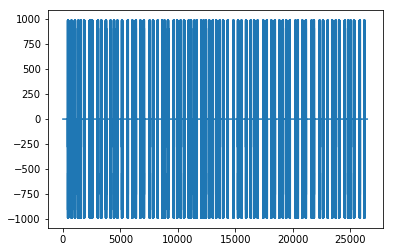

In [73]:
#load_all(path, dis, db, repeat)
fs, data = load_wav('./sample.wav')
print(data[1200:1300])
plt.plot(data)

In [74]:
def fda(x, floor, ceil, fs):
    print(fs)
    b, a = signal.butter(8, [2 * floor / fs, 2 * ceil / fs], 'bandpass')
    data = signal.filtfilt(b, a, x)
    print(data.shape)
    return data

48000
(26500,)


C:\Anaconda\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


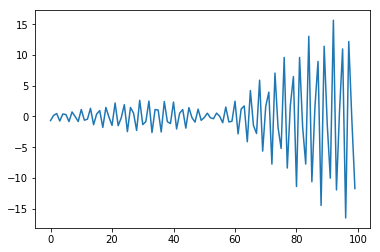

In [75]:
filted = fda(data, 17500, 18500, fs)
plt.plot(filted[1200:1300])

In [76]:
def dfft(data, f, fs):
    n = data.shape[0]
    window = 100
    impulse_fft = np.zeros((n, 1))
    for i in range(n - window):
        y = fft(data[i:i + window])
        y = np.abs(y)
        index_impulse = round(f / fs * window)
        impulse_fft[i] = np.max(y[index_impulse - 2:index_impulse + 3])
    return impulse_fft

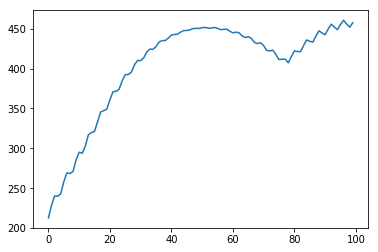

In [77]:
impulse = dfft(filted, 18000, fs)
plt.plot(impulse[1200:1300])

In [78]:
def smooth(a, window):
    a = a.squeeze()
    out = np.convolve(a, np.ones(window, dtype=int),'valid') / window
    r = np.arange(1, window - 1, 2)
    start = np.cumsum(a[:window - 1])[::2] / r
    stop = (np.cumsum(a[:-window:-1])[::2] / r)[::-1]
    return np.concatenate((start, out, stop))

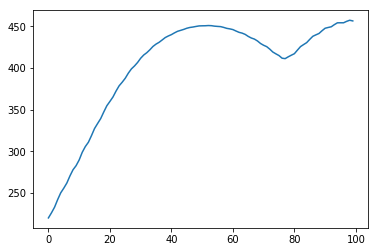

In [79]:
sm_data = smooth(impulse, 5)
plt.plot(sm_data[1200:1300])

In [80]:
def find_max(data, half_window):
    data = data / np.max(data)
    n = data.shape[0]
    position_impulse = []
    for i in range(half_window, n - half_window):
        if data[i] > 0.2 and data[i] == np.max(data[i - half_window:i + half_window + 1]):
            position_impulse.append(i)
    return position_impulse

In [81]:
impulse_pos = find_max(sm_data, 100)
print(impulse_pos)

[402, 698, 1002, 1298, 1502, 1798, 2298, 2502, 3002, 3298, 3702, 4102, 4402, 4698, 5102, 5598, 6002, 6298, 6702, 6998, 7502, 7798, 8198, 8598, 8802, 9098, 9602, 9898, 10202, 10498, 10898, 11102, 11398, 11602, 11998, 12202, 12402, 12698, 13002, 13298, 13602, 13898, 14302, 14798, 15202, 15498, 15898, 16302, 16598, 16898, 17402, 17698, 18102, 18398, 18802, 19098, 19402, 19698, 20198, 20402, 20802, 21098, 21598, 21802, 22302, 22598, 22998, 23402, 23698, 23998, 24502, 24798, 25002, 25298, 25798, 26198]


In [82]:
def demod(pos):
    N = len(pos)
    d = 100
    eps = 25
    message_2 = [0] * ((N - 1) * 2)
    for i in range(N - 1):
        delta = pos[i + 1] - pos[i] - 100
        print(delta)
        for mul in range(4):
            if abs(delta - d * (mul + 1)) < eps:
                message_2[i * 2], message_2[i * 2 + 1] = mul >> 1, mul & 1;
                break;
    return message_2

In [83]:
arr = demod(impulse_pos)
print(arr)
print(len(arr))

196
204
196
104
196
400
104
400
196
304
300
200
196
304
396
304
196
304
196
404
196
300
300
104
196
404
196
204
196
300
104
196
104
296
104
100
196
204
196
204
196
304
396
304
196
300
304
196
200
404
196
304
196
304
196
204
196
400
104
300
196
400
104
400
196
300
304
196
200
404
196
104
196
400
300
[0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0]
150


In [84]:
from binascii import unhexlify
def decode(arr):
    bin_res = ''.join(map(str, arr))
    res = ''.join([chr(int(bin_res[8*i:8*i+8], 2)) for i in range(len(bin_res) // 8)])
    return res
res = decode(arr)
print(res)

Tsinghua Universit
